In [1]:
## 数据读取+特征转换
import polars as pl
import pandas as pd
import sys
sys.path.append("..")
from utils.models import *
from utils.alpha import *
from utils.backtest import *

def transform_data(df: pl.DataFrame):
    print(df['instrument'][0])
    df = build_alpha158(df)
    df = build_label(df)
    return df

pldf = pl.read_csv("../data/cleaned/csi300_stock_feats.csv")
stock_10 = pldf.select(["instrument"]).unique().head(10)
pldf = pldf.filter(pl.col('instrument').is_in(stock_10['instrument']))
pldf = pldf.group_by('instrument').map_groups(transform_data)
# pldf = transform_data(pldf.filter(pl.col('instrument') == 'SH600009'))
# print(pldf)

/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SH601288
SH601985
SH601166
SH601258
SZ002422
SH601016
SZ000338
SH600153
SH600023
SZ002384


In [2]:
df = pldf.to_pandas()
label = 'LABEL0'
features = [col for col in df.columns if col.isupper() and col!=label]
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(['instrument', 'datetime'], inplace=True)
df.dropna(inplace=True)
df[label] = df.groupby('instrument')[label].transform(lambda x: (x - x.mean()) / x.std())

In [3]:
years = df.index.get_level_values('datetime').year
df_1617 = df[years.isin([2016, 2017])].copy()   # train
df_18 = df[years == 2018].copy()    # val
df_19 = df[years == 2019].copy()    # test

In [4]:
model = BaseModel.use_subclass('lgb')()
model.train(df_1617, df_18, features, label)

[20]	train's l2: 0.569662	valid's l2: 1.37001
[40]	train's l2: 0.491051	valid's l2: 1.38345
[60]	train's l2: 0.422941	valid's l2: 1.39301
[80]	train's l2: 0.374612	valid's l2: 1.40382
[100]	train's l2: 0.325373	valid's l2: 1.41608
[120]	train's l2: 0.284353	valid's l2: 1.42834
[140]	train's l2: 0.245183	valid's l2: 1.4388
[160]	train's l2: 0.208482	valid's l2: 1.4538
[180]	train's l2: 0.180812	valid's l2: 1.46535
[200]	train's l2: 0.15851	valid's l2: 1.47619
[220]	train's l2: 0.137802	valid's l2: 1.48719
[240]	train's l2: 0.118945	valid's l2: 1.49569
[260]	train's l2: 0.103645	valid's l2: 1.50222
[280]	train's l2: 0.0911015	valid's l2: 1.50815
[300]	train's l2: 0.0809525	valid's l2: 1.51272
[320]	train's l2: 0.0728702	valid's l2: 1.51783
[340]	train's l2: 0.0656746	valid's l2: 1.52114
[360]	train's l2: 0.0595861	valid's l2: 1.52651
[380]	train's l2: 0.0539138	valid's l2: 1.53004
[400]	train's l2: 0.0492531	valid's l2: 1.53395
[420]	train's l2: 0.0453747	valid's l2: 1.53775
[440]	train'

<IPython.core.display.Javascript object>

OrderedDict([('sharperatio', None)])
OrderedDict([(2019, 0.21720863939232649)])
AutoOrderedDict([('len', 4), ('drawdown', 1.2904276990210184), ('moneydown', 14781.20821000007)])


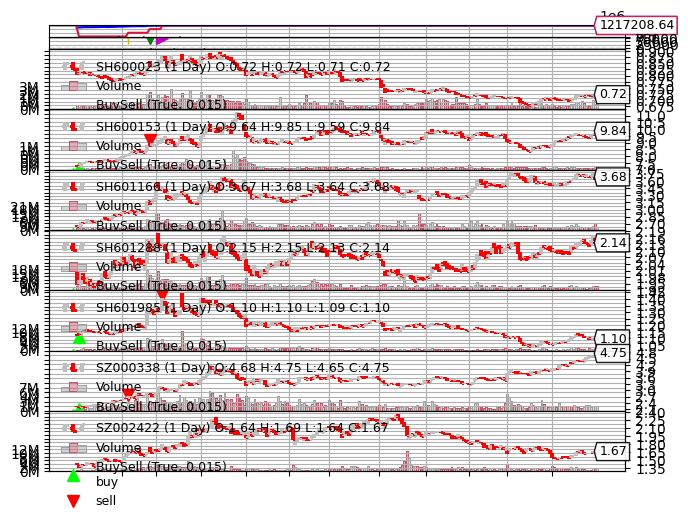

In [5]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline

# 创建Cerebro并添加数据
cerebro = bt.Cerebro()
for instrument, group in model.pred(df_19, features).groupby('instrument'):
    group = group.reset_index(level=0, drop=True)
    cerebro.adddata(MyPandasData(dataname=group), name=instrument)
cerebro.addstrategy(MyStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="SharpeRatio")
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="AnnualReturn")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="DrawDown")

cerebro.broker.set_cash(1e6) # 设定初始资金
cerebro.broker.setcommission(commission=6e-4) # 设定手续费
result = cerebro.run()
plt.figure()
cerebro.plot(style='bar')
plt.show()
print(result[0].analyzers.SharpeRatio.get_analysis())
print(result[0].analyzers.AnnualReturn.get_analysis())
print(result[0].analyzers.DrawDown.get_analysis()['max'])